In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches
import torch
from pol.datasets.objdetect import COCODataset, collate_padding_fn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random

In [2]:
def seed_all(seed):
    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [3]:
seed_all(42)

dset = COCODataset(
    dataset_name='coco-2017-validation',
    split='validation', 
    max_num_detection=10,
    evaluation=True,
    keep_original=True,
    crop_size=400)

[ Using Seed :  42  ]
Found annotations at '/mnt/lingxiao/fiftyone/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Loaded split validation with 3802 images.


In [4]:
random.seed(42)

In [5]:
def draw_img(ax, img, boxes=None, gt_boxes=None):
    img = torch.permute(img, [1, 2, 0])
    
    ax.xaxis.tick_top()
    ax.imshow(img)
    
    if boxes is not None:
        for box in boxes:
            x, y, w, h = box
            x -= 0.5 * w
            y -= 0.5 * h
            x *= img.shape[1]
            y *= img.shape[0]
            w *= img.shape[1]
            h *= img.shape[0]
            ax.add_patch(patches.Rectangle((x, y), w, h, fill=False, edgecolor='red', lw=2))
        
    if gt_boxes is not None:
        for box in gt_boxes:
            x, y, w, h = box
            x -= 0.5 * w
            y -= 0.5 * h
            x *= img.shape[1]
            y *= img.shape[0]
            w *= img.shape[1]
            h *= img.shape[0]
            ax.add_patch(patches.Rectangle((x, y), w, h, fill=False, edgecolor='green', lw=2))

In [6]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
batch_size = 8    
dataloader = DataLoader(dset, batch_size=batch_size, shuffle=False, 
                        collate_fn=collate_padding_fn, 
                       num_workers=1,
                       worker_init_fn=seed_worker)

In [7]:
#print(dset[0]['img'])

In [8]:
def vis2():
    fig2, ax2 = plt.subplots(batch_size, 1, squeeze=False)
    fig2.set_size_inches((8, 8*batch_size))
    for batch_idx, data in enumerate(dataloader):
        batch_img = data['img']
        for i in range(batch_size):
            draw_img(ax2[i, 0], batch_img[i, :, :, :])
        break
        
# vis2()

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

frcnn = fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
frcnn.eval()

/mnt/lingxiao/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


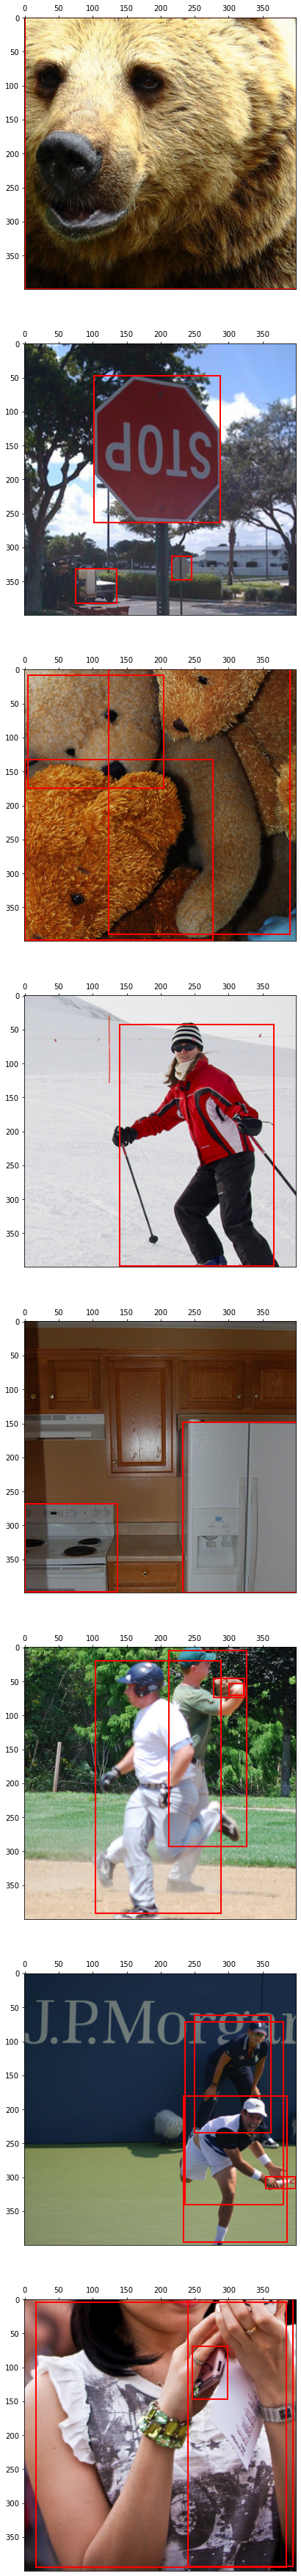

In [10]:
def convert_frcnn_box(boxes, width, height):
    result = []
    for box in boxes:
        x0, y0, x1, y1 = box
        x0 = x0 / width
        y0 = y0 / height
        x1 = x1 / width
        y1 = y1 / height
        
        x = (x0 + x1) / 2
        y = (y0 + y1) / 2
        w = x1 - x0
        h = y1 - y0
        result.append([x, y, w, h])
    return result

def filter_by_score(boxes, scores, threshold=0.75):
    result = []
    for i in range(len(boxes)):
        if scores[i] >= threshold:
            result.append(boxes[i])
    return result
        

fig3, ax3 = plt.subplots(batch_size, 1, squeeze=False)
fig3.set_size_inches((8, 8*batch_size))
for batch_idx, data in enumerate(dataloader):
    batch_img = data['img_ori'] / 255.0
    pred = frcnn(batch_img)
    for i in range(batch_size):
        img = batch_img[i]
        boxes = pred[i]['boxes'].detach()
        boxes = convert_frcnn_box(boxes, width=img.shape[1], height=img.shape[2])
        scores = pred[i]['scores']
        boxes = filter_by_score(boxes, scores)
        draw_img(ax3[i, 0], img, boxes=boxes)
    break